# Using DeepQLearning

In [69]:
import gymnasium as gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
from collections import deque, namedtuple
import random
from tqdm.auto import tqdm
from itertools import count
import math
import torch.nn.functional as F

In [70]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [71]:
# device agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

In [72]:
device

device(type='cpu')

In [73]:
env = gym.make('CartPole-v1', render_mode='human')
actions = env.action_space.n
states = env.observation_space.shape[0]

In [74]:
actions, states

(2, 4)

In [75]:
env.observation_space.shape[0]

4

### What I need

- A Replay Memory
- Two neural networks (target and policy)

In [76]:
# Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, size):
        self.memory = deque([], maxlen=size)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, minibatch_size):
        return random.sample(self.memory, minibatch_size)
    def __len__(self):
        return len(self.memory)

The Policy and Target networks are the same network

In [77]:
class DQN(nn.Module):
    def __init__(self, states, actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(states, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)

        return x

In [78]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
ALPHA = 0.0001
TAU = 0.005 # Target network update rate
REPLAY_MEMORY_SIZE = 10000

In [79]:
n_actions = env.action_space.n                # number of actions
n_states = env.observation_space.shape[0]     # number of states

n_actions, n_states

(2, 4)

In [80]:
# Setting up the network

policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.AdamW(policy_net.parameters(), lr=ALPHA, amsgrad=True)
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

In [81]:
# plots the score as it trains. found on pytorch tutorial

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [82]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [83]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


Complete


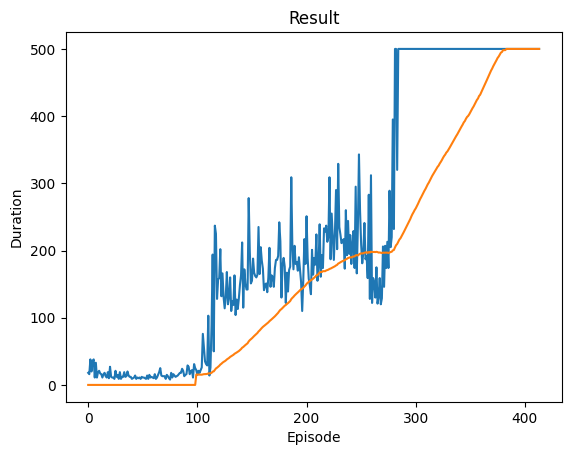

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [86]:
# Training Loop
episodes = 5
for episode in tqdm(range(episodes)):
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    
    for t in count():
        action = select_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in target_net_state_dict:
            target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]
        target_net.load_state_dict(target_net_state_dict)

        if terminated or truncated:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
state = env.reset()[0]
state = torch.tensor(state, dtype=torch.float32).to(device)

state

tensor([ 0.0179,  0.0289, -0.0491,  0.0343])

In [27]:
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

state

tensor([[ 0.0240, -0.0415, -0.0292, -0.0398]])